In [12]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
import sklearn
from sklearn import metrics
import re


In [13]:
#Data source: https://www.kaggle.com/datasets/gauthamp10/google-playstore-apps
data_folder = os.getcwd() +"/data/"
csv_name = "Google-Playstore.csv"
data_path = data_folder + csv_name

In [14]:
df = pd.read_csv(data_path)

#Feature engineering (eng) starts
eng_df = df.drop(['Installs', 'Currency', 'Minimum Installs', 'Developer Website', 'Developer Email', 'Privacy Policy', 'App Name'], axis=1)

# pak een n sample vd dataframe
eng_df_s = eng_df.sample(n=10000, random_state=123) #small
eng_df_t = eng_df.sample(n=1000, random_state=123) #tiny
eng_df_tt = eng_df.sample(n=200, random_state=123) #teeny-tiny

#Select one for further use
eng_df = eng_df

In [15]:
#What kind of Size values exist, going by the text part of the string
size_cats = eng_df['Size'].apply(lambda x: re.findall('([\sA-Za-z]*$)', str(x))[0])
print(size_cats.value_counts())

#Knowing there are three kinds of known sizes (kb, Mb, Gb) we convert these to Mb
#But because there are also missing values or OS dependent sizes, we store this categorically in an extra column
#(known sizes will be categorized as 'known')
def process_Size(value):
    value = str(value)
    conversion = {'k':0.001, 'M':1.0, 'G':1000.0}
    if value[-1] in conversion.keys():
        value = value.replace(',', '') #added because some 
        size = float(value[:-1]) * conversion[value[-1]]
        category = 'Known'
    else:
        size = None
        category = value
    return (size, category)


temp_df = pd.DataFrame(eng_df['Size'].apply(lambda x: process_Size(x)).tolist(), columns=['Size', 'Size_category'])
eng_df['Size'] = temp_df['Size'].values
eng_df['Size_category'] = temp_df['Size_category'].values
#del temp_df ##bugged, but I'd prefer to delete

M                     2201705
Varies with device      74777
k                       36253
nan                       196
G                          13
Name: Size, dtype: int64


In [16]:
#Separate quantitative columns into a quantitative dataframe
q_columns = ['Rating', 'Rating Count', 'Maximum Installs', 'Price', 'Size']
cat_columns = eng_df.columns^q_columns
q_df = eng_df[q_columns]
cat_df = eng_df[cat_columns]

#Filter, e.g. based on quantitative variable outliers or category values
standard_deviations = 3
q_df_filter = q_df.apply(lambda x: np.abs(x - x.mean()) / x.std() < standard_deviations).all(axis=1)
q_df = q_df[q_df_filter]
eng_df = eng_df[q_df_filter]
cat_df = cat_df[q_df_filter]

#Log-transform
#Needs to be edited so it's only applied to some columns (e.g. installs but not rating)
transf_q_df = q_df.apply(lambda x: np.log10(x, where=0.1<x))

C:\Users\~GerkoMolenaarTraine\AppData\Local\Temp\ipykernel_2836\2504945521.py:3: FutureWarning: Index.__xor__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__xor__.  Use index.symmetric_difference(other) instead.
  cat_columns = eng_df.columns^q_columns


In [17]:
#sns.pairplot(transf_q_df, kind="kde")
#One by one alternative: sns.distplot(col1, col2)

In [18]:
#Only run this with sufficiently small sample
#sns.pairplot(transf_q_df)

In [19]:
pd.to_datetime(df['Scraped Time']).dt.date.value_counts()

2021-06-16    1859744
2021-06-15     453200
Name: Scraped Time, dtype: int64

In [20]:
eng_df.head()


,App Id,Category,Rating,Rating Count,Maximum Installs,Free,Price,Size,Minimum Android,Developer Id,Released,Last Updated,Content Rating,Ad Supported,In App Purchases,Editors Choice,Scraped Time,Size_category
0,com.ishakwe.gakondo,Adventure,0.0,0.0,15,True,0.0,10.0,7.1 and up,Jean Confident Irénée NIYIZIBYOSE,"Feb 26, 2020","Feb 26, 2020",Everyone,False,False,False,2021-06-15 20:19:35,Known
1,com.webserveis.batteryinfo,Tools,4.4,64.0,7662,True,0.0,2.9,5.0 and up,Webserveis,"May 21, 2020","May 06, 2021",Everyone,True,False,False,2021-06-15 20:19:35,Known
2,com.doantiepvien.crm,Productivity,0.0,0.0,58,True,0.0,3.7,4.0.3 and up,Cabin Crew,"Aug 9, 2019","Aug 19, 2019",Everyone,False,False,False,2021-06-15 20:19:35,Known
3,cst.stJoseph.ug17ucs548,Communication,5.0,5.0,19,True,0.0,1.8,4.0.3 and up,Climate Smart Tech2,"Sep 10, 2018","Oct 13, 2018",Everyone,True,False,False,2021-06-15 20:19:35,Known
4,com.horodyski.grower,Tools,0.0,0.0,478,True,0.0,6.2,4.1 and up,Rafal Milek-Horodyski,"Feb 21, 2020","Nov 12, 2018",Everyone,False,False,False,2021-06-15 20:19:35,Known


<AxesSubplot:xlabel='Maximum Installs', ylabel='Rating Count'>

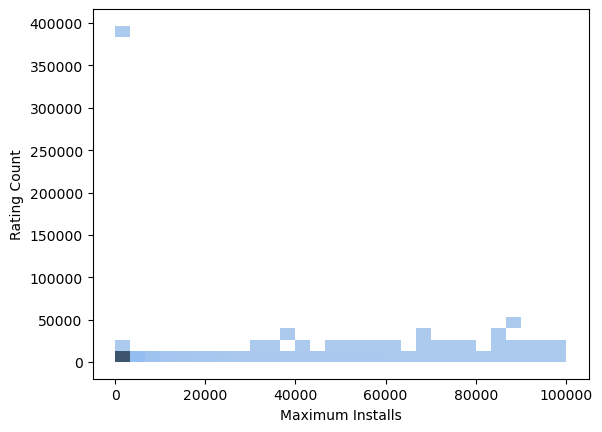

In [21]:
df_lowinstalls = eng_df.loc[(eng_df["Maximum Installs"] <100000)]
sns.histplot(data = df_lowinstalls, x="Maximum Installs", y="Rating Count", bins=30)

In [25]:
#eng_df.isnull().sum()
df_lowinstalls.loc[(df_lowinstalls["Rating Count"] > 350000)]

,App Id,Category,Rating,Rating Count,Maximum Installs,Free,Price,Size,Minimum Android,Developer Id,Released,Last Updated,Content Rating,Ad Supported,In App Purchases,Editors Choice,Scraped Time,Size_category
198186,com.google.android.apps.wellbeing,Tools,4.1,396647.0,1,True,0.0,15.0,NaN,Google LLC,"Aug 8, 2018","Jun 15, 2021",Everyone,False,False,False,2021-06-15 23:41:27,Known


In [26]:
eng_df.Category.unique()

array(['Adventure', 'Tools', 'Productivity', 'Communication', 'Social',
       'Libraries & Demo', 'Lifestyle', 'Personalization', 'Racing',
       'Maps & Navigation', 'Travel & Local', 'Food & Drink',
       'Books & Reference', 'Medical', 'Puzzle', 'Entertainment',
       'Arcade', 'Auto & Vehicles', 'Photography', 'Health & Fitness',
       'Education', 'Shopping', 'Board', 'Music & Audio', 'Sports',
       'Beauty', 'Business', 'Educational', 'Finance', 'News & Magazines',
       'Casual', 'Art & Design', 'House & Home', 'Card', 'Events',
       'Trivia', 'Strategy', 'Word', 'Video Players & Editors', 'Action',
       'Simulation', 'Music', 'Dating', 'Role Playing', 'Weather',
       'Comics', 'Parenting', 'Casino'], dtype=object)

In [34]:
#Relatie tussen verschil in (released minus last updated) en max installs
df.head()
df_idea = df[["Maximum Installs", "Released", "Last Updated"]]
df_idea.dropna()
df_idea.head()
df_idea["Released"] = pd.to_datetime(df_idea["Released"], format="%b %d, %Y")
df_idea["Last Updated"] = pd.to_datetime(df_idea["Last Updated"], format="%b %d, %Y")

df_idea.info()
df_idea["Difference"] = df_idea["Last Updated"] - df_idea["Released"]
df_idea.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2312944 entries, 0 to 2312943
Data columns (total 3 columns):
 #   Column            Dtype         
---  ------            -----         
 0   Maximum Installs  int64         
 1   Released          datetime64[ns]
 2   Last Updated      datetime64[ns]
dtypes: datetime64[ns](2), int64(1)
memory usage: 52.9 MB


C:\Users\~GerkoMolenaarTraine\AppData\Local\Temp\ipykernel_2836\1938262456.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_idea["Released"] = pd.to_datetime(df_idea["Released"], format="%b %d, %Y")
C:\Users\~GerkoMolenaarTraine\AppData\Local\Temp\ipykernel_2836\1938262456.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_idea["Last Updated"] = pd.to_datetime(df_idea["Last Updated"], format="%b %d, %Y")
C:\Users\~GerkoMolenaarTraine\AppData\Local\Temp\ipykernel_2836\1938262456.py:10: SettingWithC

,Maximum Installs,Released,Last Updated,Difference
0,15,2020-02-26,2020-02-26,0 days
1,7662,2020-05-21,2021-05-06,350 days
2,58,2019-08-09,2019-08-19,10 days
3,19,2018-09-10,2018-10-13,33 days
4,478,2020-02-21,2018-11-12,-466 days


In [39]:
df_idea['Difference'] = df_idea['Difference'].dt.days



AttributeError: Can only use .dt accessor with datetimelike values

In [40]:
df_idea.loc[df_idea["Difference"] < 0]

,Maximum Installs,Released,Last Updated,Difference
4,478,2020-02-21,2018-11-12,-466.0
1196,7196,2018-01-30,2017-11-13,-78.0
1303,289,2020-08-03,2017-05-07,-1184.0
1724,162,2019-12-21,2019-10-10,-72.0
2177,252,2020-03-06,2020-01-01,-65.0
...,...,...,...,...
2312321,66,2019-11-27,2019-11-09,-18.0
2312670,1316,2020-03-27,2019-11-11,-137.0
2312706,36864,2018-07-17,2015-01-12,-1282.0
2312742,6613,2017-12-09,2017-05-03,-220.0


In [41]:
df_ideas = df_idea.loc[df_idea["Difference"] >= 0]

<AxesSubplot:xlabel='Difference', ylabel='Maximum Installs'>

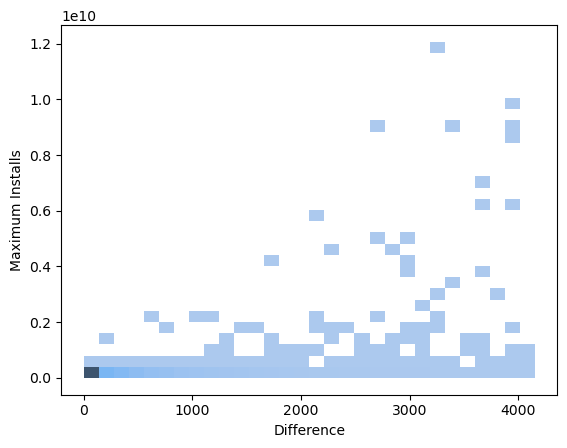

In [45]:
sns.histplot(data=df_ideas, x="Difference", y="Maximum Installs", bins=30)

2024367


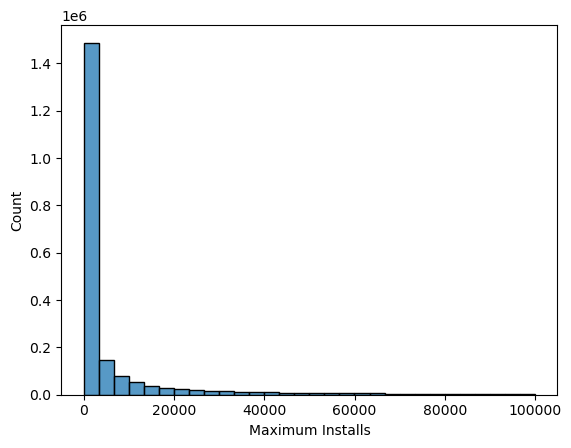

In [56]:
eng_df_limit = eng_df.loc[eng_df["Maximum Installs"] < 100000]
sns.histplot(data=eng_df_limit, x="Maximum Installs", bins=30)
print(len(eng_df_limit.index))


In [57]:
eng_df_limit[eng_df_limit.columns[1]].count()

2024367